In [40]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.driver.memory", "15g") \
    .appName("MelbournePedistrian") \
    .getOrCreate()

sc = spark.sparkContext

In [41]:
import math

oversampling = True
train_part_num = 10
test_part_num = 1
k = 1
in_k = max(math.floor(k/train_part_num), 1)

In [42]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, stddev
from pyspark.sql.functions import col, isnan, when, count

def load_and_preprocess(train_path, test_path):
    schema = StructType([
        StructField("Class", StringType(), True),
        StructField("0hr", FloatType(), True),
        StructField("1hr", FloatType(), True),
        StructField("2hr", FloatType(), True),
        StructField("3hr", FloatType(), True),
        StructField("4hr", FloatType(), True),
        StructField("5hr", FloatType(), True),
        StructField("6hr", FloatType(), True),
        StructField("7hr", FloatType(), True),
        StructField("8hr", FloatType(), True),
        StructField("9hr", FloatType(), True),
        StructField("10hr", FloatType(), True),
        StructField("11hr", FloatType(), True),
        StructField("12hr", FloatType(), True),
        StructField("13hr", FloatType(), True),
        StructField("14hr", FloatType(), True),
        StructField("15hr", FloatType(), True),
        StructField("16hr", FloatType(), True),
        StructField("17hr", FloatType(), True),
        StructField("18hr", FloatType(), True),
        StructField("19hr", FloatType(), True),
        StructField("20hr", FloatType(), True),
        StructField("21hr", FloatType(), True),
        StructField("22hr", FloatType(), True),
        StructField("23hr", FloatType(), True)
    ])
    train_df = spark.read.format("csv").option("delimiter", "\t").schema(schema).load(train_path)
    test_df = spark.read.format("csv").option("delimiter", "\t").schema(schema).load(test_path)

    from pyspark.sql.functions import rand

    train_df = train_df.orderBy(rand(seed=42))
    test_df = test_df.orderBy(rand(seed=42))

    merged_df = train_df.union(test_df)

    # Replace NaN values
    for column in merged_df.columns[1:]:
        median = merged_df.approxQuantile(column, [0.5], 0.25)[0]
        merged_df = merged_df.na.fill(median, [column])

    return merged_df

In [43]:
merged_df = load_and_preprocess(
    "../data/MelbournePedestrian/MelbournePedestrian_TRAIN.tsv", 
    "../data/MelbournePedestrian/MelbournePedestrian_TEST.tsv"
    )

# Show the resulting dataframe
merged_df.count()

3633

In [ ]:
merged_df = merged_df.limit(1000)

In [44]:
# Define the split ratio
train_ratio = 0.7
test_ratio = 0.3

# Split the data into train and test sets
train_df, test_df = merged_df.randomSplit([train_ratio, test_ratio], seed=346)

In [45]:
train_df.groupBy("Class").count().show()

+-----+-----+
|Class|count|
+-----+-----+
|    3|  248|
|   10|  263|
|    4|  258|
|    7|  264|
|    5|  262|
|    1|  260|
|    2|  264|
|    6|  259|
|    9|  255|
|    8|  245|
+-----+-----+



In [46]:
train_df.count()

2578

In [47]:
# train_df.cache()
# test_df.cache()

In [48]:
# for df in [train_df, test_df]:
#     duplicates_df = df.dropDuplicates()
#     num_duplicates = df.count() - duplicates_df.count()
#     if num_duplicates > 0:
#         print("There are duplicate rows in the DataFrame.")
#     else:
#         print("There are no duplicate rows in the DataFrame.")

In [49]:
import pyspark.sql.functions as F
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
import pandas as pd

In [50]:
train_rdd = train_df.rdd.repartition(train_part_num)
column_names = df.columns

In [51]:
def toPandas_partition(instances):
    panda_df = pd.DataFrame(columns = column_names)      # using the global variable
    
    for instance in instances:  # each instance is of Row type
        panda_df = pd.concat([panda_df, pd.DataFrame([instance.asDict()])], ignore_index=True)
  
    return [panda_df]

rdd_pandas = train_rdd.mapPartitions(toPandas_partition)

In [52]:
import random

def build_model(partition):

    knn = KNeighborsTimeSeriesClassifier(n_neighbors=in_k, metric='dtw')
    
    X_train = partition.drop('Class', axis=1)
    y_train = partition['Class']
    
    model = knn.fit(X_train, y_train)

    return model

model = rdd_pandas.map(build_model).collect()

In [53]:
test_rdd  = test_df.rdd.repartition(test_part_num)
test_rdd_pandas = test_rdd.mapPartitions(toPandas_partition)

In [54]:
def test_classifier(partition):
    predictions = []
    distances = []
    X_test = partition.drop('Class', axis=1).values
    
    for m in model:
        neighbors = m.kneighbors(X_test)
        pred = m.predict(X_test).tolist()
        distances.append(neighbors[0].tolist())
        predictions.append(pred)

    return predictions, distances

def get_majority_vote(predictions):
    return max(set(predictions), key=predictions.count)

def predict_class(partition):
    predictions, distances = test_classifier(partition)
    predicted_labels = []

    for i in range(len(predictions[0])):
        class_votes = []
        dist_votes = []
        for j in range(len(predictions)):
            class_votes.append(predictions[j][i])
            dist_votes.append(distances[j][i])

        k_nearest = sorted(zip(dist_votes, class_votes), key=lambda x: x[0])[:k]
        majority_class = get_majority_vote([x[1] for x in k_nearest])
        # print("CLASS VOTES:\n", class_votes)
        # print("MAJORITY CLASS:", majority_class)
        predicted_labels.append(majority_class)

    return predicted_labels

predictions = test_rdd_pandas.map(predict_class).flatMap(lambda x: x)

In [55]:
y_pred = predictions.collect()

Exception in thread "serve RDD 729" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [56]:
y_test = test_df.select("Class").collect()

In [57]:
from pyspark.sql.functions import when, count

y_pred_df = spark.createDataFrame([(i,) for i in y_pred], ['prediction'])
y_test_df = spark.createDataFrame(y_test, ['Class'])

In [58]:
from pyspark.sql.functions import monotonically_increasing_id

y_pred_df = y_pred_df.withColumn("id", monotonically_increasing_id())
y_test_df = y_test_df.withColumn("id", monotonically_increasing_id())

joined_df = y_pred_df.join(y_test_df, "id", "outer").drop("id")

joined_df = joined_df.withColumn('same_values', when(joined_df.prediction == joined_df.Class, 1).otherwise(0))

print("joined_df:")
joined_df.show(100)

joined_df:


+----------+-----+-----------+
|prediction|Class|same_values|
+----------+-----+-----------+
|         6|    6|          1|
|         8|    8|          1|
|         6|    3|          0|
|         7|    7|          1|
|         3|    8|          0|
|         9|    9|          1|
|         9|    9|          1|
|        10|   10|          1|
|         2|    2|          1|
|         6|    6|          1|
|        10|   10|          1|
|        10|   10|          1|
|         9|    3|          0|
|         7|    5|          0|
|         6|    6|          1|
|         6|    6|          1|
|         2|    2|          1|
|         2|    2|          1|
|         3|    3|          1|
|         1|    1|          1|
|         7|    7|          1|
|         2|    8|          0|
|         7|    7|          1|
|         4|    4|          1|
|         5|    5|          1|
|        10|   10|          1|
|         4|    4|          1|
|         7|    7|          1|
|         6|    6|          1|
|       

In [59]:
percentage_same_values = joined_df.agg({'same_values': 'mean'}).collect()[0][0] * 100

print(f"{percentage_same_values:.2f}% of rows have the same label and prediction.")

83.79% of rows have the same label and prediction.


In [60]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

indexed_df = joined_df.withColumn("ClassIndex", col("Class").cast("integer"))

# Cast the prediction column to DoubleType
indexed_df = indexed_df.withColumn("prediction", col("prediction").cast("double"))

# Compute F1 score
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="ClassIndex", metricName="f1")
f1_score = evaluator.evaluate(indexed_df)
print(f"F1 score: {f1_score:.2f}")

F1 score: 0.84


In [61]:
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

indexed_df = indexed_df.withColumn("ClassIndexDb", col("ClassIndex").cast("double"))

# Calculate the confusion matrix
predictions_and_labels = indexed_df.select(["prediction", "ClassIndexDb"]).rdd
metrics = MulticlassMetrics(predictions_and_labels)

confusion_matrix = metrics.confusionMatrix().toArray()

# Define list of class labels
classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


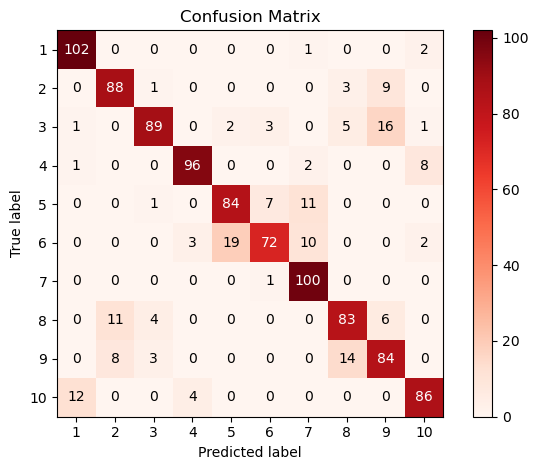

In [62]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Reds')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set ticks and tick labels
ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Loop over data dimensions and create text annotations.
thresh = confusion_matrix.max() / 2.
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix[i])):
        ax.text(j, i, format(confusion_matrix[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
fig.tight_layout()
plt.show()